# Derin Öğrenme İle Ses Sinyali Sınıflandırması

Projenin ilk aşamasında veri setimizi analiz için hazırlayacağız ve Mel-Frekans Cepstral Katsayılarını (MFCC) kullanarak ses dosyalarından ses sinyali özelliklerini çıkaracağız.


Sonrasında bir Evrişimli Sinir Ağları (CNN) modeli oluşturacağız ve modelimizi veri setimiz ile eğiteceğiz.


Son olarak, modelimizi kullanarak bir ses dosyasının sınıfını tahmin edeceğiz.

Her sinyalin kendine has özellikleri vardır. Ses işlemede, Mel-Frekans Cepstrum (MFC), bir sesin kısa vadeli güç spektrumunun bir temsilidir. Mel-Frekans Cepstral katsayıları (MFCC'ler), topluca bir MFC oluşturan katsayılardır.


Böylece librosa kütüphanesini kullanarak veri kümemizdeki her ses sinyalinin özelliklerini alıp bir listede tutacağız.

In [5]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

In [7]:
# Öncelikle librosanın ses sinyallerini nasıl işlediğini görelim.
# Librosa kullanarak örnek bir ses sinyali okuyalım.

audio_file_path='UrbanSound8K/audio/fold3/17973-2-0-32.wav'

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [8]:
# Librosa hakkında bilmemiz gereken en önemli şey, librosanın herhangi bir stereo sinyali mono'ya dönüştürmesidir.
# Bu mono sinyal formu üzerinden ses dosyasının sinyal özellikleri:

print(librosa_audio_data)

[ 0.05806023  0.04728271 -0.02169256 ... -0.00860656  0.03410248
  0.09018897]


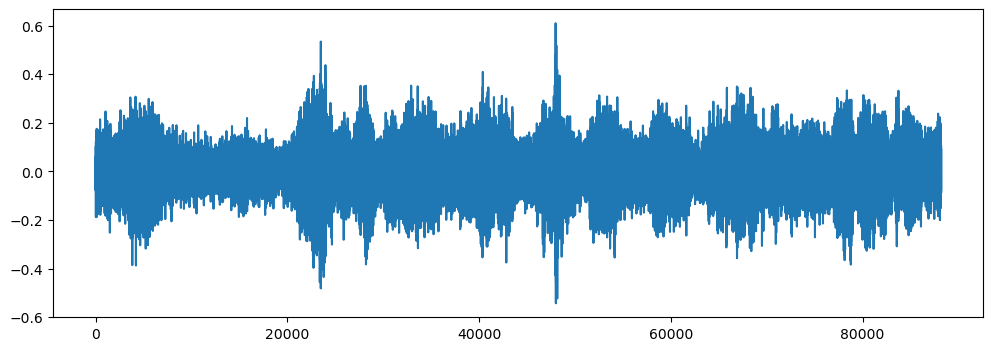

In [9]:
# Librosa ses verilerini çizelim.
# 1 kanallı orijinal ses :

plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

Aslında örneğimiz stereo, scipy kullanarak görebiliriz :

In [10]:
# Scipy ile okuyalım.

from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path)

In [11]:
wave_audio

array([[2189, 3314],
       [1592, 2598],
       [ 848, 1712],
       ...,
       [1326, 2602],
       [1915, 3542],
       [2542, 4449]], dtype=int16)

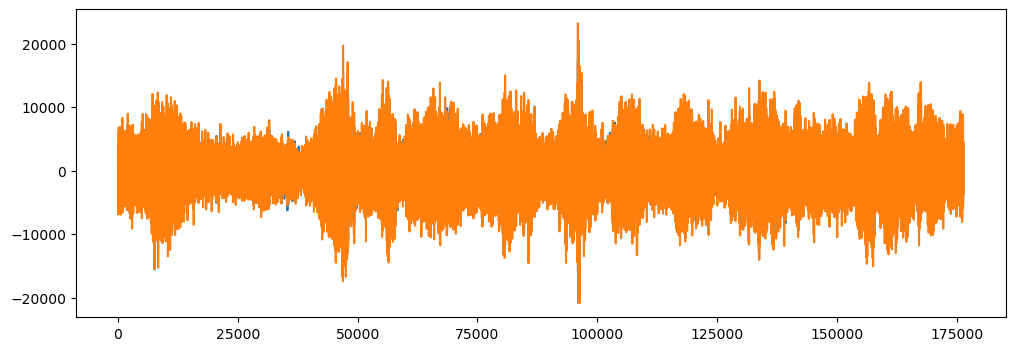

In [12]:
# İki kanallı orijinal ses :

plt.figure(figsize=(12, 4))
plt.plot(wave_audio)
plt.show()

ÖZELLİK ÇIKARMA :

Burada ses örneklerinden Mel-Frekans Cepstral Katsayılarını (MFCC) kullanacağız. MFCC, pencere boyutu boyunca frekans dağılımını özetler, böylece sesin hem frekansını hem de zaman özelliklerini analiz etmek mümkündür. Bu sesli temsiller, sınıflandırma için özellikleri tanımlamamıza izin verecektir.

In [13]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)   #n_mfcc: döndürülecek MFCC sayısı 
print(mfccs.shape)

(40, 173)


In [14]:
mfccs

array([[-167.09666  , -152.27574  , -172.7387   , ..., -192.53252  ,
        -179.42377  , -179.9042   ],
       [  77.15352  ,   94.49202  ,  109.3145   , ...,  107.66588  ,
          87.717316 ,   67.726715 ],
       [-108.97769  , -119.88193  , -128.7536   , ..., -112.772415 ,
         -98.41925  ,  -86.16422  ],
       ...,
       [  -9.484234 ,   -8.975718 ,  -14.13222  , ...,   -6.595039 ,
          -1.9226968,   -5.5306387],
       [   4.7791624,    3.693905 ,    5.1923394, ...,   -4.6435237,
         -12.0100975,  -17.334637 ],
       [   5.1541758,    7.426703 ,    7.043156 , ...,   -2.6938493,
          -6.3918614,   -7.203297 ]], dtype=float32)

In [15]:
# Veri kümesindeki her ses dosyası için MFCC'leri çıkaracağız.

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [16]:
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [17]:
# Şimdi Mel-Frekans Cepstral Katsayılarını kullanarak her bir ses dosyasını tekrarlıyoruz ve özellikleri ayıklıyoruz.

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [10:16,  7.11it/s]C:\Users\ceyda\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8325it [23:17,  6.03it/s]C:\Users\ceyda\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
8327it [23:17,  7.84it/s]C:\Users\ceyda\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [24:22,  5.97it/s]


In [18]:
# Extracted_features'ı Pandas veri çerçevesine dönüştüreceğiz.

extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22339, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [19]:
# Daha sonra veri setini bağımsız ve bağımlı veri setine ayırdık

X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [20]:
X.shape

(8732, 40)

In [21]:
X

array([[-2.1735526e+02,  7.0223389e+01, -1.3038527e+02, ...,
        -1.6930531e+00, -6.1698347e-01,  3.8600507e-01],
       [-4.2409818e+02,  1.0934077e+02, -5.2919525e+01, ...,
         5.3489321e-01, -5.4468733e-01,  4.4632089e-01],
       [-4.5879114e+02,  1.2138419e+02, -4.6520657e+01, ...,
         2.0768483e+00,  1.6962967e+00, -9.6140957e-01],
       ...,
       [-3.0388824e+02,  1.1135945e+02, -4.5941566e+01, ...,
        -3.0292377e+00,  2.7170298e+00,  7.6197419e+00],
       [-3.4411008e+02,  1.2545021e+02, -5.4903442e+01, ...,
        -7.9082441e+00, -1.6414586e+00,  5.6668439e+00],
       [-3.1560281e+02,  9.4854805e+01, -3.7222340e+01, ...,
         6.1386454e-01, -1.1449189e+01, -6.0105853e+00]], dtype=float32)

In [22]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [23]:
y.shape

(8732,)

In [24]:
# Modelimizde 1 ve 0 olacak şekilde etiket kodlaması yapmalıyız.
# 1 0 0 0 0 0 0 0 0 0 => air_conditioner
# 0 1 0 0 0 0 0 0 0 0 => car_horn
# 0 0 1 0 0 0 0 0 0 0 => children_playing
# 0 0 0 1 0 0 0 0 0 0 => dog_bark
# ...
# 0 0 0 0 0 0 0 0 0 1 => street_music

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [25]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [27]:
# Veri setini Train ve Test olarak ayırdık.

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [28]:
X_train

array([[-1.31104706e+02,  1.12505905e+02, -2.25746956e+01, ...,
         3.24665260e+00, -1.36902368e+00,  2.75575471e+00],
       [-1.36703424e+01,  9.10850830e+01, -7.79273319e+00, ...,
        -3.25305080e+00, -5.27745247e+00, -1.55697143e+00],
       [-4.98715439e+01,  2.65353173e-01, -2.05009365e+01, ...,
         2.85459447e+00, -1.60920465e+00,  3.52480578e+00],
       ...,
       [-4.27012360e+02,  9.26230469e+01,  3.12939763e+00, ...,
         7.42641389e-01,  7.33490944e-01,  7.11009085e-01],
       [-1.45754608e+02,  1.36265778e+02, -3.35155220e+01, ...,
         1.46811950e+00, -2.00917006e+00, -8.82181883e-01],
       [-4.21031342e+02,  2.10654541e+02,  3.49066067e+00, ...,
        -5.38886738e+00, -3.37136054e+00, -1.56651151e+00]], dtype=float32)

In [29]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train.shape

(6985, 40)

In [31]:
X_test.shape

(1747, 40)

In [32]:
y_train.shape

(6985, 10)

In [33]:
y_test.shape

(1747, 10)

Evrişimli Sinir Ağları (CNN) Modeli Oluşturma ve Modelimizi UrbanSound8K Veri Kümesi ile Eğitme :

In [34]:
# Kaç sınıfımız var? Onu kendi modelimizde kullanmalıyız.

num_labels = 10

In [35]:
# Şimdi CNN modelimizi oluşturmaya başlıyoruz

model=Sequential()
# 1. gizli katman
model.add(Dense(125,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2. gizli katman
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. gizli katman
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# çıktı katmanı
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5125      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [37]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [38]:
# Modeli eğitelim.

epochscount = 300
num_batch_size = 32

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/300
219/219 [==============================] - 6s 17ms/step - loss: 10.5595 - accuracy: 0.1257 - val_loss: 2.2753 - val_accuracy: 0.1654
Epoch 2/300
219/219 [==============================] - 2s 10ms/step - loss: 2.5208 - accuracy: 0.1274 - val_loss: 2.2609 - val_accuracy: 0.1231
Epoch 3/300
219/219 [==============================] - 2s 7ms/step - loss: 2.2955 - accuracy: 0.1380 - val_loss: 2.2295 - val_accuracy: 0.1202
Epoch 4/300
219/219 [==============================] - 2s 7ms/step - loss: 2.2246 - accuracy: 0.1696 - val_loss: 2.1542 - val_accuracy: 0.1666
Epoch 5/300
219/219 [==============================] - 2s 8ms/step - loss: 2.1670 - accuracy: 0.1918 - val_loss: 2.0289 - val_accuracy: 0.2284
Epoch 6/300
219/219 [==============================] - 2s 8ms/step - loss: 2.1230 - accuracy: 0.2105 - val_loss: 1.9874 - val_accuracy: 0.2650
Epoch 7/300
219/219 [==============================] - 3s 13ms/step - loss: 2.0869 - accuracy: 0.2233 - val_loss: 1.9539 - val_accuracy: 0.

Epoch 58/300
219/219 [==============================] - 3s 16ms/step - loss: 0.9630 - accuracy: 0.6832 - val_loss: 0.7848 - val_accuracy: 0.7527
Epoch 59/300
219/219 [==============================] - 4s 20ms/step - loss: 0.9649 - accuracy: 0.6743 - val_loss: 0.7732 - val_accuracy: 0.7539
Epoch 60/300
219/219 [==============================] - 3s 14ms/step - loss: 0.9606 - accuracy: 0.6807 - val_loss: 0.7989 - val_accuracy: 0.7361
Epoch 61/300
219/219 [==============================] - 2s 10ms/step - loss: 0.9657 - accuracy: 0.6795 - val_loss: 0.7751 - val_accuracy: 0.7550
Epoch 62/300
219/219 [==============================] - 2s 7ms/step - loss: 0.9444 - accuracy: 0.6859 - val_loss: 0.7515 - val_accuracy: 0.7613
Epoch 63/300
219/219 [==============================] - 2s 7ms/step - loss: 0.9591 - accuracy: 0.6776 - val_loss: 0.7607 - val_accuracy: 0.7642
Epoch 64/300
219/219 [==============================] - 2s 10ms/step - loss: 0.9454 - accuracy: 0.6863 - val_loss: 0.7675 - val_accu

219/219 [==============================] - 3s 12ms/step - loss: 0.8240 - accuracy: 0.7201 - val_loss: 0.6673 - val_accuracy: 0.7985
Epoch 115/300
219/219 [==============================] - 3s 12ms/step - loss: 0.8417 - accuracy: 0.7184 - val_loss: 0.6615 - val_accuracy: 0.7905
Epoch 116/300
219/219 [==============================] - 3s 14ms/step - loss: 0.8604 - accuracy: 0.7141 - val_loss: 0.6538 - val_accuracy: 0.8054
Epoch 117/300
219/219 [==============================] - 2s 10ms/step - loss: 0.8576 - accuracy: 0.7173 - val_loss: 0.6692 - val_accuracy: 0.7939
Epoch 118/300
219/219 [==============================] - 2s 7ms/step - loss: 0.8426 - accuracy: 0.7175 - val_loss: 0.6621 - val_accuracy: 0.7951
Epoch 119/300
219/219 [==============================] - 2s 7ms/step - loss: 0.8271 - accuracy: 0.7203 - val_loss: 0.6758 - val_accuracy: 0.7956
Epoch 120/300
219/219 [==============================] - 2s 7ms/step - loss: 0.8351 - accuracy: 0.7211 - val_loss: 0.6610 - val_accuracy: 0.

219/219 [==============================] - 3s 13ms/step - loss: 0.8007 - accuracy: 0.7271 - val_loss: 0.6215 - val_accuracy: 0.8100
Epoch 171/300
219/219 [==============================] - 2s 8ms/step - loss: 0.7633 - accuracy: 0.7452 - val_loss: 0.5862 - val_accuracy: 0.8214
Epoch 172/300
219/219 [==============================] - 2s 8ms/step - loss: 0.7784 - accuracy: 0.7433 - val_loss: 0.6276 - val_accuracy: 0.8077
Epoch 173/300
219/219 [==============================] - 2s 10ms/step - loss: 0.7930 - accuracy: 0.7403 - val_loss: 0.5976 - val_accuracy: 0.8174
Epoch 174/300
219/219 [==============================] - 5s 21ms/step - loss: 0.8110 - accuracy: 0.7373 - val_loss: 0.6321 - val_accuracy: 0.8031
Epoch 175/300
219/219 [==============================] - 4s 20ms/step - loss: 0.7995 - accuracy: 0.7324 - val_loss: 0.5898 - val_accuracy: 0.8208
Epoch 176/300
219/219 [==============================] - 2s 9ms/step - loss: 0.7872 - accuracy: 0.7404 - val_loss: 0.6314 - val_accuracy: 0.

219/219 [==============================] - 3s 14ms/step - loss: 0.7509 - accuracy: 0.7523 - val_loss: 0.5993 - val_accuracy: 0.8151
Epoch 227/300
219/219 [==============================] - 3s 13ms/step - loss: 0.7441 - accuracy: 0.7526 - val_loss: 0.5732 - val_accuracy: 0.8163
Epoch 228/300
219/219 [==============================] - 2s 9ms/step - loss: 0.7568 - accuracy: 0.7530 - val_loss: 0.5989 - val_accuracy: 0.8174
Epoch 229/300
219/219 [==============================] - 2s 8ms/step - loss: 0.7721 - accuracy: 0.7536 - val_loss: 0.5942 - val_accuracy: 0.8163
Epoch 230/300
219/219 [==============================] - 2s 7ms/step - loss: 0.7837 - accuracy: 0.7387 - val_loss: 0.5945 - val_accuracy: 0.8237
Epoch 231/300
219/219 [==============================] - 2s 7ms/step - loss: 0.7433 - accuracy: 0.7518 - val_loss: 0.5945 - val_accuracy: 0.8191
Epoch 232/300
219/219 [==============================] - 4s 18ms/step - loss: 0.7628 - accuracy: 0.7492 - val_loss: 0.5797 - val_accuracy: 0.8

219/219 [==============================] - 2s 11ms/step - loss: 0.7267 - accuracy: 0.7598 - val_loss: 0.5743 - val_accuracy: 0.8145
Epoch 283/300
219/219 [==============================] - 4s 16ms/step - loss: 0.7336 - accuracy: 0.7569 - val_loss: 0.5603 - val_accuracy: 0.8323
Epoch 284/300
219/219 [==============================] - 3s 15ms/step - loss: 0.7216 - accuracy: 0.7623 - val_loss: 0.5890 - val_accuracy: 0.8180
Epoch 285/300
219/219 [==============================] - 3s 13ms/step - loss: 0.7410 - accuracy: 0.7563 - val_loss: 0.5886 - val_accuracy: 0.8254
Epoch 286/300
219/219 [==============================] - 2s 10ms/step - loss: 0.7282 - accuracy: 0.7566 - val_loss: 0.5707 - val_accuracy: 0.8208
Epoch 287/300
219/219 [==============================] - 2s 8ms/step - loss: 0.7347 - accuracy: 0.7635 - val_loss: 0.6075 - val_accuracy: 0.8168
Epoch 288/300
219/219 [==============================] - 2s 11ms/step - loss: 0.7649 - accuracy: 0.7519 - val_loss: 0.5771 - val_accuracy: 

In [39]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.8076702952384949


In [40]:
X_test[1]

array([-466.17957   ,    1.0950238 ,  -34.01389   ,   35.33935   ,
        -14.88148   ,  -19.12843   ,   -0.581684  ,  -16.130579  ,
        -21.339075  ,    7.673634  ,  -29.16449   ,  -18.950253  ,
         -2.9579995 ,   -8.16233   ,  -15.153101  ,   -6.604805  ,
         -7.5685983 ,    9.340646  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340122 ,  -19.228804  ,   -4.630231  ,
         -1.0564744 ,    3.215267  ,   -6.984281  ,  -16.414577  ,
        -10.0286455 ,   13.009954  ,    0.53346074,  -23.843391  ,
        -15.267321  ,    9.245734  ,   10.367627  ,   -0.58320105,
         -1.2624055 ,   17.700016  ,   13.847463  ,   -5.1862826 ],
      dtype=float32)

In [41]:
predictions = np.argmax(model.predict(X_test), axis=-1)

55/55 [==============================] - 0s 3ms/step


Sonrasında CNN Modelimizi Kullanarak Bir Ses Dosyasının Sınıfını Tahmin Ediyoruz :

Önce yeni ses verilerini işliyoruz ve ardından sınıfı tahmin ediyoruz.

In [42]:
filename="UrbanSound8K/audio/edinburgh.wav"

#Diğer ses dosyası için filename="UrbanSound8K/audio/PoliceSiren.wav"

sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [43]:
print(mfccs_scaled_features)

[-2.4529930e+02  1.2536964e+02  8.0924463e+00  2.5726080e+01
  1.0990156e+00  1.0344976e+01 -6.1558037e+00  6.6783214e+00
  1.5565388e+00  6.0036783e+00 -1.9089441e+00  9.1686935e+00
 -3.7009203e+00  6.4144349e+00 -3.2760167e+00  1.2811542e+01
  7.8237444e-01  5.1237712e+00 -9.8404837e-01  5.4883838e+00
 -1.0705056e+00  3.1159060e+00 -3.5323622e+00  5.6360817e+00
 -2.9950500e-01  1.7367420e+00  3.9943048e-01  1.0572122e+00
 -1.5246512e+00  4.7839798e-02 -8.8152277e-01 -5.2109151e+00
 -4.6591549e+00 -4.9605527e+00  1.1615901e-01 -4.3678198e+00
 -1.6980239e+00 -2.3132145e+00  1.4586025e+00 -4.1361609e+00]


In [44]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [45]:
mfccs_scaled_features.shape

(1, 40)

In [46]:
print(mfccs_scaled_features)

[[-2.4529930e+02  1.2536964e+02  8.0924463e+00  2.5726080e+01
   1.0990156e+00  1.0344976e+01 -6.1558037e+00  6.6783214e+00
   1.5565388e+00  6.0036783e+00 -1.9089441e+00  9.1686935e+00
  -3.7009203e+00  6.4144349e+00 -3.2760167e+00  1.2811542e+01
   7.8237444e-01  5.1237712e+00 -9.8404837e-01  5.4883838e+00
  -1.0705056e+00  3.1159060e+00 -3.5323622e+00  5.6360817e+00
  -2.9950500e-01  1.7367420e+00  3.9943048e-01  1.0572122e+00
  -1.5246512e+00  4.7839798e-02 -8.8152277e-01 -5.2109151e+00
  -4.6591549e+00 -4.9605527e+00  1.1615901e-01 -4.3678198e+00
  -1.6980239e+00 -2.3132145e+00  1.4586025e+00 -4.1361609e+00]]


In [47]:
print(mfccs_scaled_features.shape)

(1, 40)


In [48]:
result_array = model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 81ms/step


In [49]:
result_array

array([[0.03331232, 0.01457805, 0.2818849 , 0.12577766, 0.03922256,
        0.02320643, 0.02008839, 0.00301333, 0.01938126, 0.43953508]],
      dtype=float32)

In [50]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

street_music
